In [2]:
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve, log_loss,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
)

In [29]:
data = pd.read_csv('/Users/edatkinson/Repos/canDrivr-Indel/canDrivr/Annotated_data.csv',sep=',') 

data = data.drop(columns=['pos','ref_allele','alt_allele', 'WTtrinuc', 'mutTrinuc','mutant_AA','WT_AA'])
data = data.replace(np.nan, 0)

# data.to_csv('experimental_data.csv', sep=',', index=False)

In [31]:
X = data.drop(columns=['driver_stat', 'chrom'])
y = data['driver_stat']
X.columns = range(X.shape[1])


In [32]:
groups = data['chrom'] #For LOCO CV
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

logo = LeaveOneGroupOut()
scores = cross_val_score(xgb_model, X, y, cv=logo, groups=groups, scoring='accuracy')
print(f"LOGO-CV accuracy scores for each group: {scores}")
print(f"Mean LOGO-CV accuracy: {np.mean(scores)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))


print("Classification Report:\n", classification_report(y_test, y_pred))

LOGO-CV accuracy scores for each group: [0.69827586 0.75925926 0.74242424 0.77857143 0.76315789 0.82258065
 0.8125     0.6875     0.72463768 0.75       0.52819549 0.74626866
 0.7037037  0.69565217 0.75714286 0.7037037  0.52835052 0.77941176
 0.79411765 0.77192982 0.79761905 0.775     ]
Mean LOGO-CV accuracy: 0.7327273816678207
Test Set Accuracy: 0.8221957040572793
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       434
           1       0.84      0.78      0.81       404

    accuracy                           0.82       838
   macro avg       0.82      0.82      0.82       838
weighted avg       0.82      0.82      0.82       838



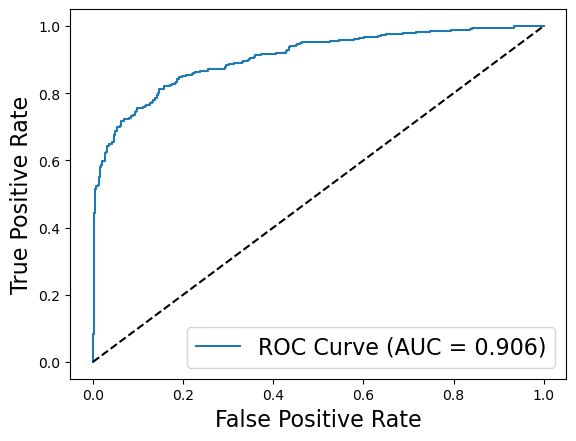

ROC AUC Score: 0.9057124606469863


In [50]:
# correlations = X.assign(driver_stat=y).corr()['driver_stat'].drop('driver_stat')
# high_correlation_features = correlations[correlations.abs() > 0.5]
# print("Highly correlated features with the target:\n", high_correlation_features)
# Calculate ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.rcParams['text.usetex'] = False  # Disable LaTeX rendering

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label=r'ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate", fontsize=16)  # Adjust x-label font size
plt.ylabel("True Positive Rate", fontsize=16)  # Adjust y-label font size
plt.legend(loc="lower right", fontsize=16)  # Set legend font size here
plt.show()

print(f"ROC AUC Score: {roc_auc}")


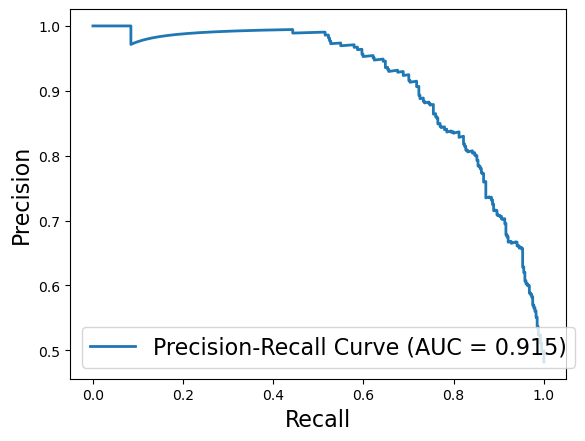

Precision-Recall AUC Score: 0.9147991804670004


In [49]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.3f})', linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
# plt.title("Precision-Recall Curve")
plt.legend(loc="lower left", fontsize=16)
plt.show()
print(f"Precision-Recall AUC Score: {pr_auc}")